# But first, import!

In [1]:
# our core libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor

# Next, load the data..

To `netmaps_df` we load "netmaps" which are subject-specific “parcellated connectomes” – for each subject, a nodes x nodes network matrix. See more [here](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP1200-DenseConnectome+PTN+Appendix-July2017.pdf).

To `behavioral_df` we load the data keys. See more [here](https://wiki.humanconnectome.org/display/PublicData/HCP-YA+Data+Dictionary-+Updated+for+the+1200+Subject+Release). 

In [2]:
N = 100
netmaps_df = pd.read_csv('data/connectivityml/HCP_PTN1200/netmats/3T_HCP1200_MSMAll_d'+str(N)+'_ts2/netmats1.txt', delim_whitespace=True,header=None)
print("Network-matrices data shape:", netmaps_df.shape)
netmaps_df.head()

Network-matrices data shape: (1003, 10000)


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,-1.5323,35.936,-4.9815,-4.75670,1.38060,2.0624,5.8417,5.1702,-6.5932,...,1.80010,4.40690,3.27060,1.710300,3.5560,0.81577,2.21120,3.6853,4.4970,0
1,0,-4.3627,22.130,-19.5240,10.12900,-7.16490,5.8310,-2.0110,-3.2240,-10.0470,...,-0.54435,0.82136,-0.15673,0.002443,1.9650,1.17590,-0.66842,2.5284,1.4772,0
2,0,-3.3764,17.130,-23.8620,0.46252,12.34500,-1.8014,-2.3384,-1.0635,8.3071,...,0.55043,-2.20120,6.05880,5.583500,6.0867,-1.64230,-2.68150,2.4673,2.4039,0
3,0,1.5948,13.595,-31.2170,0.16253,-0.18071,1.1656,-3.6007,3.8794,-5.8619,...,1.21400,0.64097,1.24110,2.465400,3.3396,-0.94855,0.91456,1.6053,2.8845,0
4,0,10.9680,17.322,-19.1960,-13.93100,8.61630,1.8109,-6.5545,20.7600,10.0900,...,1.39450,0.94140,1.41880,0.719040,3.4329,0.98975,-0.17552,1.3239,2.5881,0


In [3]:
behavioral_df = pd.read_csv('data/connectivityml/unrestricted_pkalra_7_26_2021_17_39_25.csv')
print("Behaviora data shape:", behavioral_df.shape)
behavioral_df.head()

Behaviora data shape: (1206, 582)


,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


We have netmaps for 1003 subjects so we will need to filter `behavioral_df` a little.

To `subjectsID_df` we load the ordered list of all subjects with complete rfMRI data (recon 1 + recon2) included in this PTN release

In [4]:
subjectsID_df = pd.read_csv('data/connectivityml/HCP_PTN1200/subjectIDs.txt',header=None,names=["Subject"])
print("Subjects ID data shape:", subjectsID_df.shape)
subjectsID_df.head()

Subjects ID data shape: (1003, 1)


,Subject
0,100206
1,100307
2,100408
3,100610
4,101006


We can see that this corresponds to the number of netmaps we have.

In [5]:
filter_behavioral_df = subjectsID_df.merge(behavioral_df, on='Subject', how='inner')

print("Filtered behaviora data shape:", filter_behavioral_df.shape)
filter_behavioral_df.head()

Filtered behaviora data shape: (1003, 582)


,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
2,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
3,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
4,101006,S500,Q06,F,31-35,True,2,2,4,100.0,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80


# Ok, now let's visualize what we have:

In [6]:
filter_behavioral_df.columns

Index(['Subject', 'Release', 'Acquisition', 'Gender', 'Age',
       '3T_Full_MR_Compl', 'T1_Count', 'T2_Count', '3T_RS-fMRI_Count',
       '3T_RS-fMRI_PctCompl',
       ...
       'Noise_Comp', 'Odor_Unadj', 'Odor_AgeAdj', 'PainIntens_RawScore',
       'PainInterf_Tscore', 'Taste_Unadj', 'Taste_AgeAdj', 'Mars_Log_Score',
       'Mars_Errs', 'Mars_Final'],
      dtype='object', length=582)

### Histograms

y_age shape: (1003,)
y_MMSE_Score shape: (1003,)
y_PSQI_Score shape: (1003,)


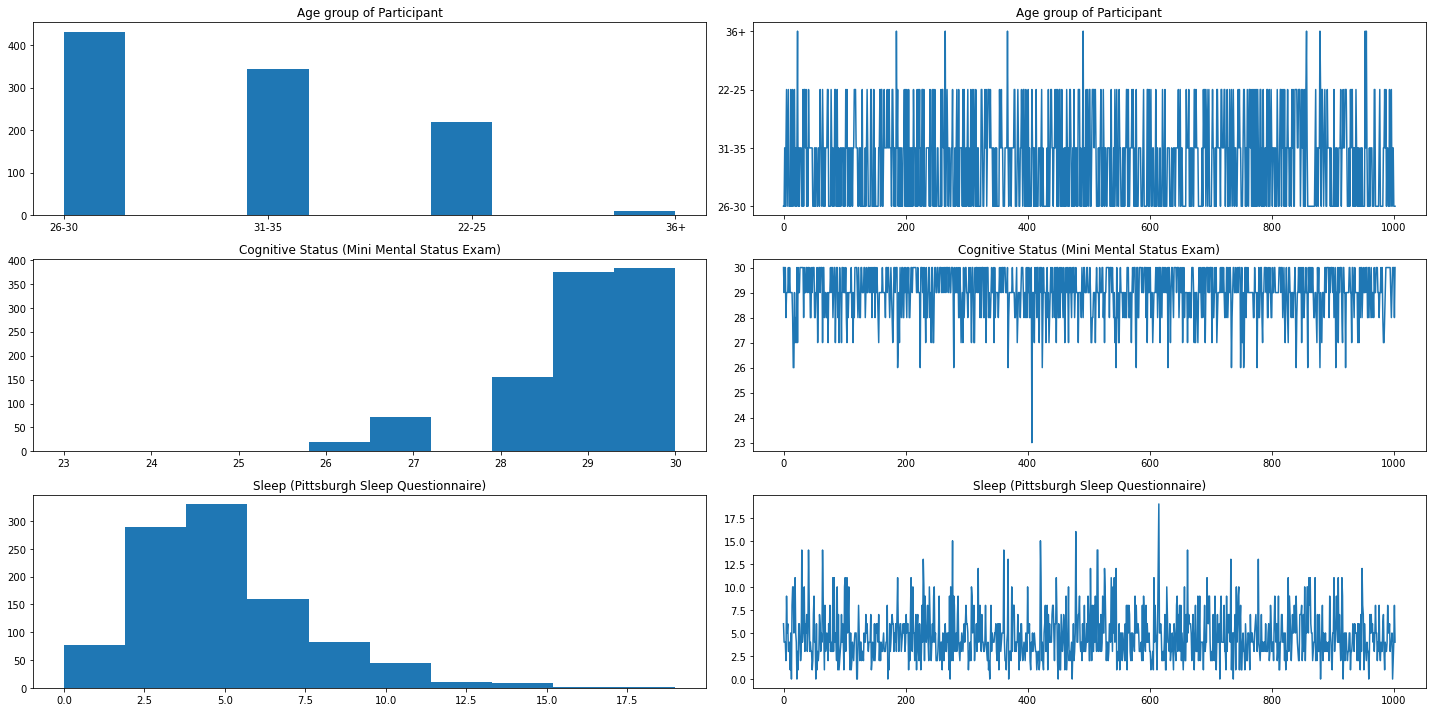

In [7]:
X = netmaps_df.values

y_age = filter_behavioral_df.Age # Age group of Participant, banded in five-year increments
print("y_age shape:", y_age.dropna().shape)
y_MMSE_Score = filter_behavioral_df.MMSE_Score # Cognitive Status (Mini Mental Status Exam)
print("y_MMSE_Score shape:", y_MMSE_Score.dropna().shape)
y_PSQI_Score = filter_behavioral_df.PSQI_Score # Sleep (Pittsburgh Sleep Questionnaire)
print("y_PSQI_Score shape:", y_PSQI_Score.dropna().shape)

fig, ax = plt.subplots(3,2,figsize=(20, 10))
ax[0][0].hist(y_age)
ax[0][0].set_title("Age group of Participant")
ax[1][0].hist(y_MMSE_Score)
ax[1][0].set_title("Cognitive Status (Mini Mental Status Exam)")
ax[2][0].hist(y_PSQI_Score)
ax[2][0].set_title("Sleep (Pittsburgh Sleep Questionnaire)")

ax[0][1].plot(y_age)
ax[0][1].set_title("Age group of Participant")
ax[1][1].plot(y_MMSE_Score)
ax[1][1].set_title("Cognitive Status (Mini Mental Status Exam)")
ax[2][1].plot(y_PSQI_Score)
ax[2][1].set_title("Sleep (Pittsburgh Sleep Questionnaire)")

fig.tight_layout()

### Countplots for each of our categorical variables.

/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


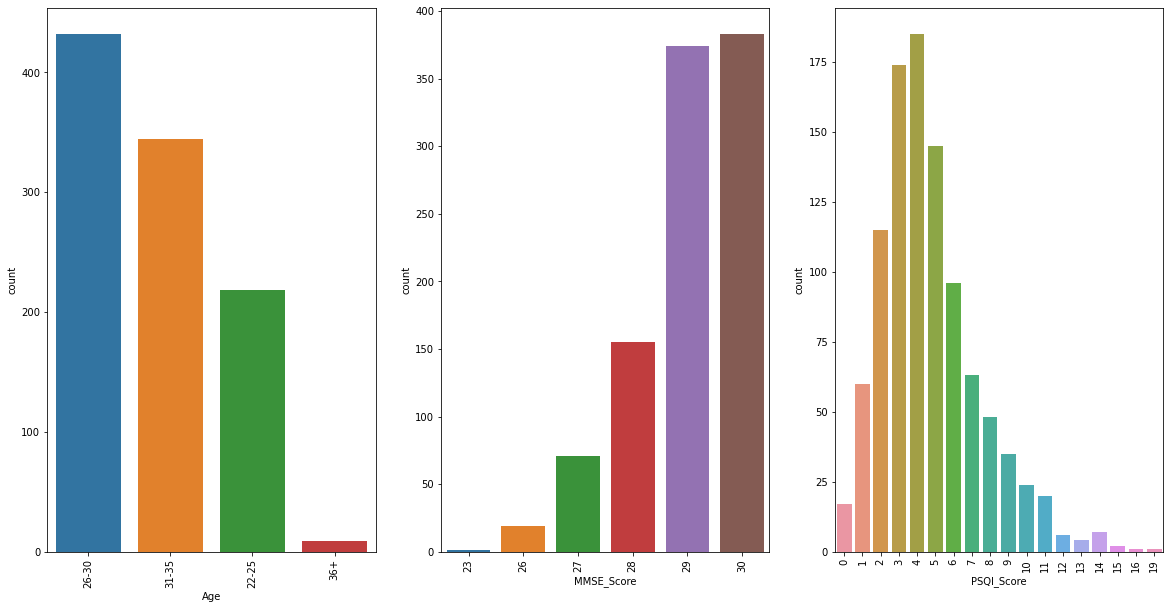

In [8]:
allY = [y_age,y_MMSE_Score,y_PSQI_Score]
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for variable, subplot in zip([0,1,2], ax.flatten()):
    sns.countplot(allY[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

# What would be the right estimator for our data?

See more [here](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

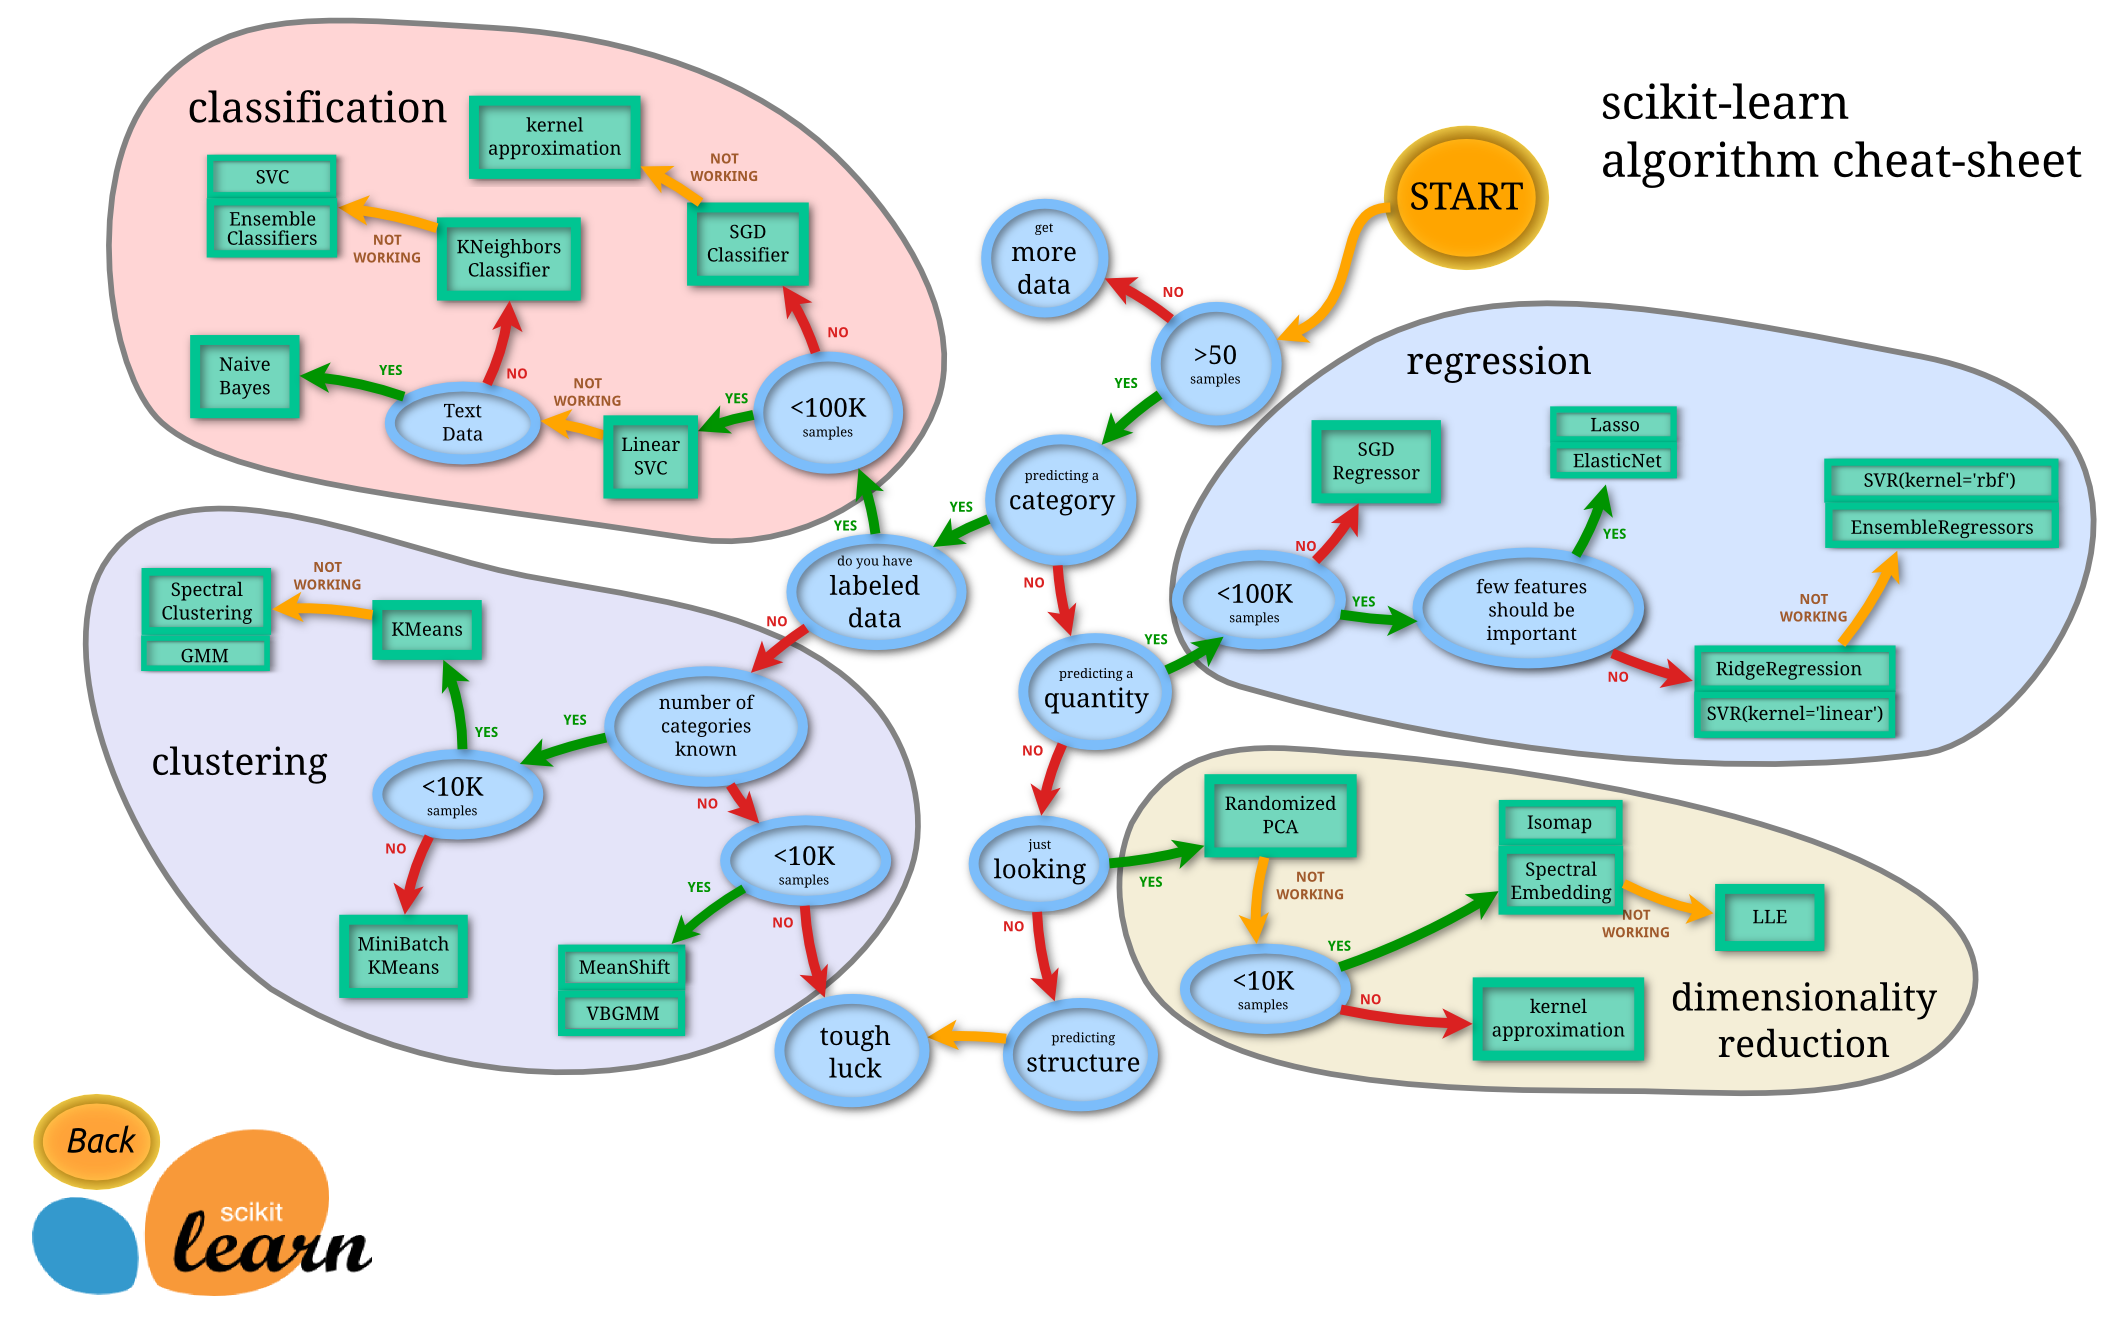

## Linear Support Vector Classifier (SVC)

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC).

### Age group of Participant, banded in five-year increments

Let's try to predict the age group of subjects in our dataset from our network-matrices data.

First we need to split the data into train and test - 

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_age, test_size=0.2)

Next, we'll use the LinearSVC, fit the model on train data and check the model accuracy score.

In [10]:
lsvc = make_pipeline(StandardScaler(),svm.LinearSVC())

In [11]:
lsvc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = lsvc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

Test set score:  0.43283582089552236


In [12]:
cv_scores = cross_val_score(lsvc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.50


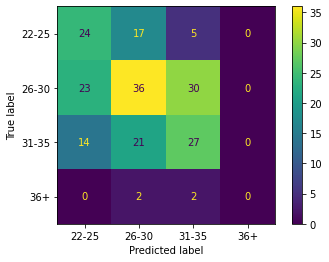

In [13]:
ypred = lsvc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(lsvc, xtest, ytest) # Plot Confusion Matrix.

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

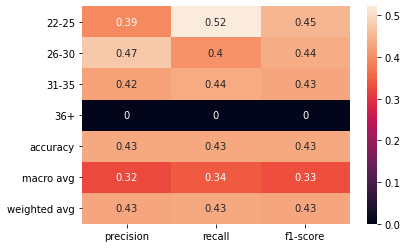

In [14]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

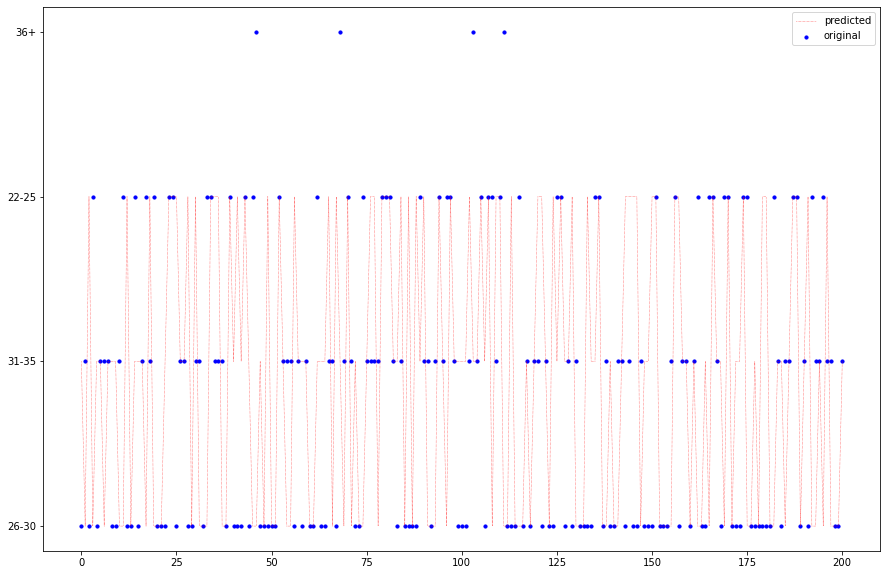

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

### Cognitive Status (Mini Mental Status Exam)

We will now repeat the steps above to try to predict the Cognitive Status (Mini Mental Status Exam) of subjects in our dataset from our network-matrices data.

In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_MMSE_Score, test_size=0.2)
lsvc = make_pipeline(StandardScaler(),svm.LinearSVC())
lsvc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = lsvc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

Test set score:  0.373134328358209


In [17]:
cv_scores = cross_val_score(lsvc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


CV average score: 0.32


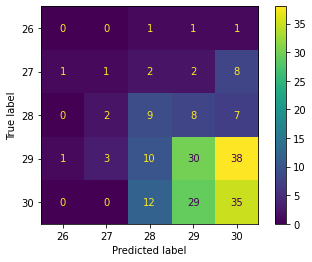

In [18]:
ypred = lsvc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(lsvc, xtest, ytest) # Plot Confusion Matrix.

<AxesSubplot:>

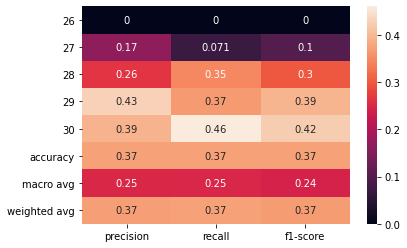

In [19]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

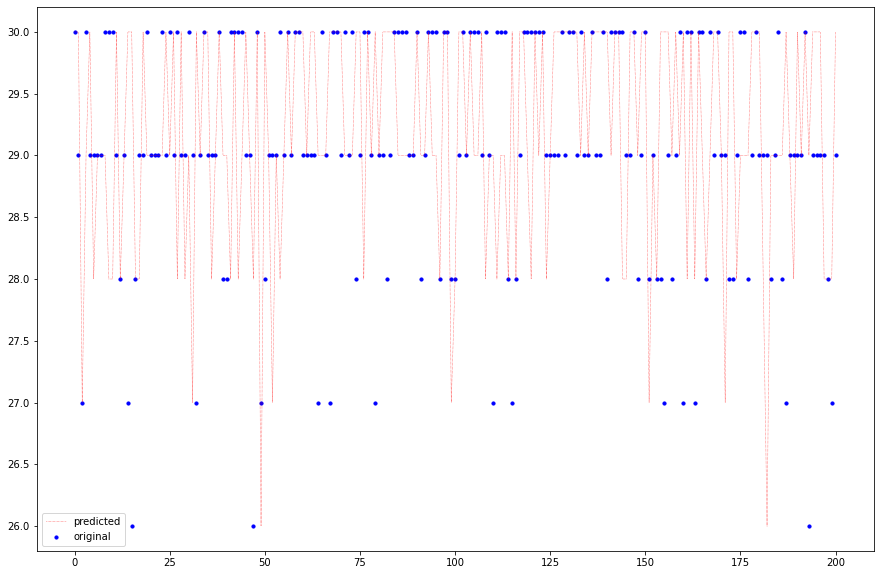

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

### Sleep (Pittsburgh Sleep Questionnaire)

and now again for sleep (Pittsburgh Sleep Questionnaire)

In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_PSQI_Score, test_size=0.2)
lsvc = make_pipeline(StandardScaler(),svm.LinearSVC())
lsvc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = lsvc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

Test set score:  0.14427860696517414


In [22]:
cv_scores = cross_val_score(lsvc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


CV average score: 0.11


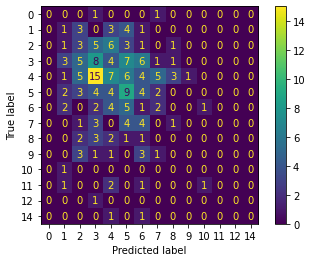

In [23]:
ypred = lsvc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(lsvc, xtest, ytest) # Plot Confusion Matrix.

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

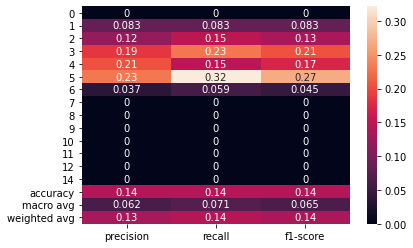

In [24]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

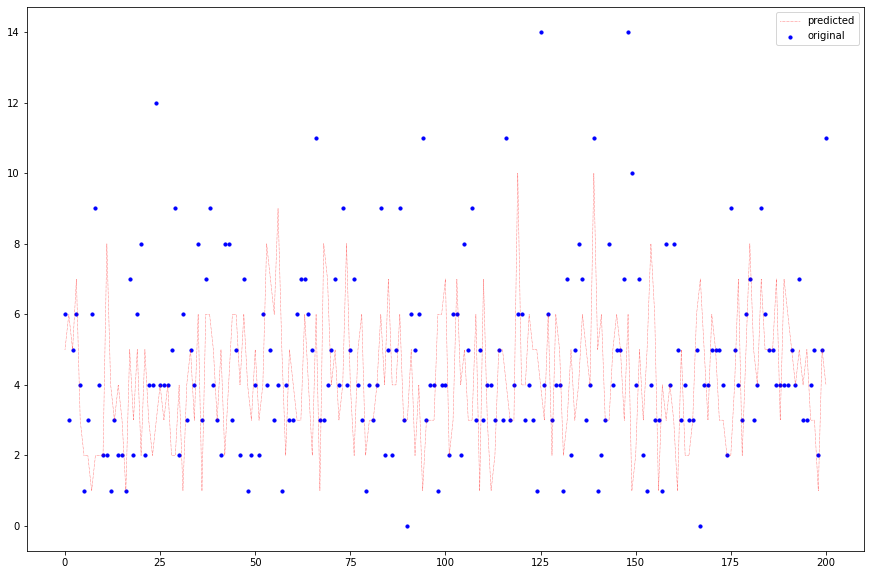

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

## Support Vector Classifier (SVC)

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC).

### Age group of Participant, banded in five-year increments

In [26]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_age, test_size=0.2)
svc = make_pipeline(StandardScaler(),svm.SVC())
svc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = svc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

Test set score:  0.5024875621890548


In [27]:
cv_scores = cross_val_score(svc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.50


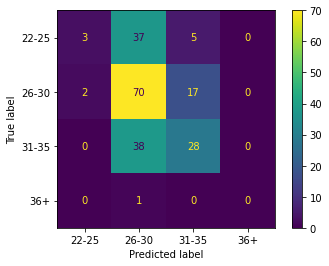

In [28]:
ypred = svc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(svc, xtest, ytest) # Plot Confusion Matrix.

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

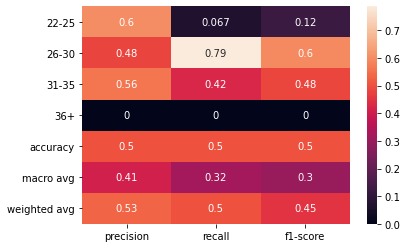

In [29]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

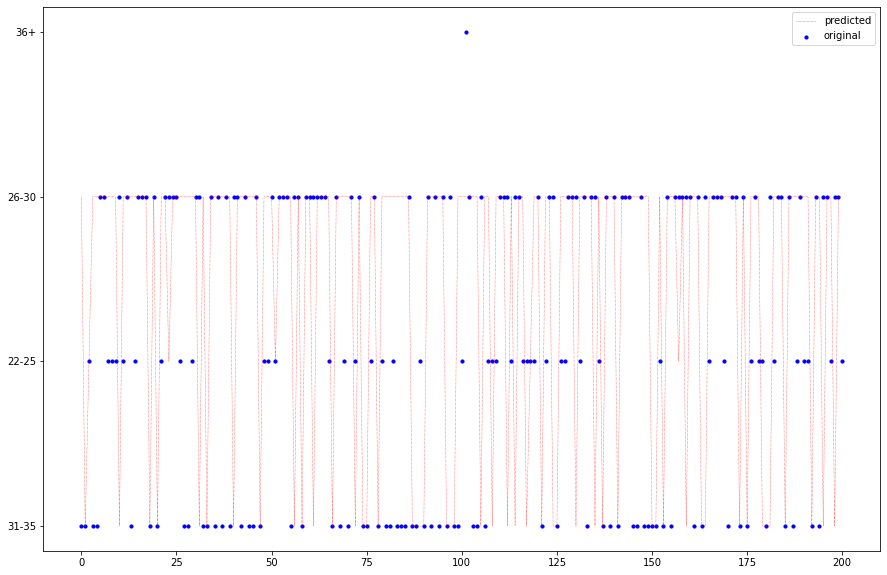

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

### Cognitive Status (Mini Mental Status Exam)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_MMSE_Score, test_size=0.2)
svc = make_pipeline(StandardScaler(),svm.SVC())
svc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = svc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

In [ ]:
cv_scores = cross_val_score(svc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

In [ ]:
ypred = svc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(svc, xtest, ytest) # Plot Confusion Matrix.

In [ ]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

## KNeighborsClassifier

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier).

### Age group of Participant, banded in five-year increments


In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_age, test_size=0.2)

In [ ]:
knc = KNeighborsClassifier(n_neighbors = 4)
knc.fit(xtrain, ytrain)

score = knc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

In [ ]:
cv_scores = cross_val_score(knc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

In [ ]:
ypred = knc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(knc, xtest, ytest) # Plot Confusion Matrix.

In [ ]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

## Regression based on k-nearest neighbors

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor).

Age group of Participant, banded in five-year increments will not work since catagorical...

### Cognitive Status (Mini Mental Status Exam)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_MMSE_Score, test_size=0.2)

In [ ]:
for n_neighbors in range(2,7):
    print("n_neighbors = ", n_neighbors)
    kng = make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors = n_neighbors))
    kng.fit(xtrain, ytrain)

    score = kng.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
    print("Test set score: ", score)
    
    cv_scores = cross_val_score(kng, xtest, ytest, cv=3)
    print("CV average score: %.2f" % cv_scores.mean())
    
    ypred = kng.predict(xtest) # Predict class labels for samples in X.
    mse = mean_squared_error(ytest, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse*(1/2.0)) 
    
    print("\n")

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

### Sleep (Pittsburgh Sleep Questionnaire)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_PSQI_Score, test_size=0.2)

In [ ]:
for n_neighbors in range(2,7):
    print("n_neighbors = ", n_neighbors)
    kng = make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors = n_neighbors))
    kng.fit(xtrain, ytrain)

    score = kng.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
    print("Test set score: ", score)
    
    cv_scores = cross_val_score(kng, xtest, ytest, cv=3)
    print("CV average score: %.2f" % cv_scores.mean())
    
    ypred = kng.predict(xtest) # Predict class labels for samples in X.
    mse = mean_squared_error(ytest, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse*(1/2.0)) 
    
    print("\n")

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

## Stochastic Gradient Descent (SGD)

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html).

Age group of Participant, banded in five-year increments will not work since catagorical...

### Cognitive Status (Mini Mental Status Exam)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_MMSE_Score, test_size=0.2)

In [ ]:
reg = make_pipeline(StandardScaler(),SGDRegressor())

In [ ]:
reg.fit(xtrain, ytrain) # Fit linear model with Stochastic Gradient Descent.
score = reg.score(xtest, ytest) # Return the coefficient of determination  of the prediction.
print("Test set R-squared:", score)

In [ ]:
cv_scores = cross_val_score(reg, xtest, ytest, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

In [ ]:
ypred = reg.predict(xtest) # Predict class labels for samples in X.
mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

### Sleep (Pittsburgh Sleep Questionnaire)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_PSQI_Score, test_size=0.2)

In [ ]:
reg = make_pipeline(StandardScaler(),SGDRegressor())

In [ ]:
reg.fit(xtrain, ytrain) # Fit linear model with Stochastic Gradient Descent.
score = reg.score(xtest, ytest) # Return the coefficient of determination  of the prediction.
print("Test set R-squared:", score)

In [ ]:
cv_scores = cross_val_score(reg, xtest, ytest, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

In [ ]:
ypred = reg.predict(xtest) # Predict class labels for samples in X.
mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()